In [ ]:
#!/usr/bin/env python
# coding: utf-8

In[1]:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 231)
pd.set_option('display.max_columns', 100)
np.random.seed(0)

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    return df
def filter_by_percentile(df, by, lower_pct=None, upper_pct=99):
    assert df[by].isnull().sum() == 0
    if lower_pct is None:
        low = -np.inf
    else:
        low = np.percentile(df[by], lower_pct)
    up = np.percentile(df[by], upper_pct)
    return df[(df[by] <= up) & (df[by] >= low)].copy()
def bin_occur_in_group(df, group_by, bin_col):
    count = df.groupby(group_by).size().to_frame(name='count').reset_index()
    occur = df.groupby(group_by)[bin_col].sum().to_frame(
        name='occur').reset_index()
    pct = count.merge(occur)
    pct['pct'] = pct['occur'] / pct['count']
    return pct.sort_values(['count'], ascending=False)
class OneHotEncoder():
    def __init__(self, cols):
        self.cols = cols
        self.encoder = {}
        self.inversed_encoder = {}
    def _get_uniq_no_nan(self, arr):
        return sorted([v for v in arr.unique() if not pd.isna(v)])
    def _get_val2id(self, arr):
        val2id = {v: i for i, v in enumerate(self._get_uniq_no_nan(arr))}
        val2id[np.nan] = -1
        return val2id
    def _get_id2val(self, val2id):
        return {i: v for v, i in val2id.items()}
    def fit(self, x):
        for col in self.cols:
            val2id = self._get_val2id(x[col])
            id2val = self._get_id2val(val2id)
            self.encoder[col] = val2id
            self.inversed_encoder[col] = id2val
        return self
    def transform(self, x):
        for col in self.encoder.keys():
            for val, i in self.encoder[col].items():
                if val is np.nan:
                    x[f'{col}_{val}'] = (x[col].isnull()).astype(int)
                else:
                    x[f'{col}_{val}'] = (x[col] == val).astype(int)
            x = x.drop(col, axis=1)
        return x
def bar_count(df, bar_col, split_col=None, size=(8, 8), xrotate=0):
    ax = sns.countplot(data=df, x=bar_col, hue=split_col)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotate)
    ax.get_figure().set_size_inches(size)
    ax.set_title(f'Count {bar_col}')
    ax.set_ylabel(f'Count')
    return ax

In [4]:
def bar_mean(df, bar_col, mean_col, split_col=None, size=(8, 8), xrotate=0):
    ax = sns.barplot(x=bar_col, y=mean_col, data=df, hue=split_col)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotate)
    ax.get_figure().set_size_inches(size)
    ax.set_title(f'Average {mean_col} for {bar_col}')
    ax.set_ylabel(f'Average {mean_col}')
    return ax
def box(df, box_col, dist_col=None, outlier_pct=0.05, split_col=None, size=(8, 8), xrotate=0):
    ax = sns.boxenplot(x=box_col, y=dist_col, data=df,
                       outlier_prop=outlier_pct, hue=split_col)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotate)
    ax.get_figure().set_size_inches(size)
    ax.set_title(f'{dist_col} distribution for {box_col}')
    return ax
def violin(df, box_col, dist_col=None, split_col=None, size=(8, 8), xrotate=0):
    ax = sns.violinplot(x=box_col, y=dist_col, data=df,
                        hue=split_col, inner='quartile')
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=xrotate)
    ax.get_figure().set_size_inches(size)
    ax.set_title(f'{dist_col} distribution for {box_col}')
    return ax
def hist(df, dist_col, size=(8, 8), bins=None):
    ax = sns.distplot(df[dist_col], bins=bins, kde=False)
    ax.get_figure().set_size_inches(size)
    ax.set_title(f'{dist_col} distribution for')
    return ax
def scatter(df, x_col, y_col, fit_reg=False,
            color_col=None, split_col=None,
            num_col_per_row=None, size=(8, 8)):
    g = sns.lmplot(
        data=df, x=x_col, y=y_col, hue=color_col,
        col=split_col, col_wrap=num_col_per_row,
        fit_reg=fit_reg
    )
    g.fig.set_size_inches(size)
    return g.axes

In[2]:

In [5]:
import math
import seaborn as sns
import scipy.stats as ss
from collections import Counter

In [6]:
REPLACE = 'replace'
DROP = 'drop'
DROP_SAMPLES = 'drop_samples'
DROP_FEATURES = 'drop_features'
SKIP = 'skip'
DEFAULT_REPLACE_VALUE = 0.0
    
def remove_incomplete_samples(x, y):
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]

In [7]:
def replace_nan_with_value(x, y, value):
    x = [v if v == v and v is not None else value for v in x]  # NaN != NaN
    y = [v if v == v and v is not None else value for v in y]
    return x, y

In [8]:
def cramers_v(x, y, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [9]:
train = pd.read_csv("./data/train.gz")

In [10]:
print("train shape:", train.shape)

train shape: (40428967, 24)


In [11]:
train.head(20)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157
5,1.000072e+19,0,14102100,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd,1,0,16920,320,50,1899,0,431,100077,117
6,1.000072e+19,0,14102100,1005,0,8fda644b,25d4cfcd,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,b264c159,be6db1d7,1,0,20362,320,50,2333,0,39,-1,157
7,1.000092e+19,0,14102100,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,be74e6fe,1,0,20632,320,50,2374,3,39,-1,23
8,1.000095e+19,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,37e8da74,5db079b5,1,2,15707,320,50,1722,0,35,-1,79
9,1.000126e+19,0,14102100,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23


In [12]:
train.dtypes

id                  float64
click                 int64
hour                  int64
C1                    int64
banner_pos            int64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
dtype: object

In[7]:

In [13]:
train.isnull().sum().sum()

0

In [14]:
train = downcast_dtypes(train)

In [15]:
cols = [col for col in train.columns if col not in ["id", "hour", "click"]]
train[cols] = train[cols].astype("category")
train.dtypes

id                   float32
click                  int32
hour                   int32
C1                  category
banner_pos          category
site_id             category
site_domain         category
site_category       category
app_id              category
app_domain          category
app_category        category
device_id           category
device_ip           category
device_model        category
device_type         category
device_conn_type    category
C14                 category
C15                 category
C16                 category
C17                 category
C18                 category
C19                 category
C20                 category
C21                 category
dtype: object

# EDA

### click

0    33563901
1     6865066
Name: click, dtype: int64

%0 : 0.830194375235954
%1 : 0.16980562476404604


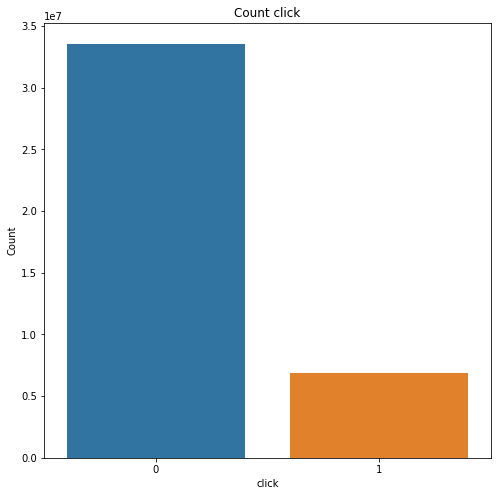

In [17]:
label = "click"
train[label].value_counts()
print("%0 :", train[label].value_counts()[0]/len(train))
print("%1 :", train[label].value_counts()[1]/len(train))
bar_count(train, label)

In [18]:
col = "id"
train.loc[1:40000000, col].nunique()
train[col].describe()

21765005

count    4.042897e+07
mean     7.655031e+18
std      5.325443e+18
min      5.211594e+11
25%      4.611181e+18
50%      9.223224e+18
75%      1.383561e+19
max      1.844674e+19
Name: id, dtype: float64

In [19]:
train.iloc[[1000 * i for i in range(0,20)],]

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1000,1.014359e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,52aa6971,8a4875bd,1,0,15706,320,50,1722,0,35,-1,79
2000,1.028691e+19,1,14102100,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,dc91c5b1,9b7ee94c,1,0,19771,320,50,2227,0,687,-1,48
3000,1.043080e+19,1,14102100,1002,0,763a42b5,4c26e9ba,50e219e0,ecad2386,7801e8d9,07d7df22,9c825afa,bf4bc264,72dab84d,0,0,19665,320,50,2253,2,303,-1,52
4000,1.056598e+19,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,54c664bf,d787e91b,1,0,20366,320,50,2333,0,39,-1,157
5000,1.070360e+19,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,2f8c9a7a,d9b5648e,0f2161f8,a99f214a,706c2b4f,b4b19c97,1,0,20744,320,50,2394,0,175,100111,116
6000,1.083543e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,677fec91,36d749e5,1,0,15702,320,50,1722,0,35,-1,79
7000,1.097383e+19,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,d4d211ce,d4d902df,a5bce124,1,0,20634,320,50,2374,3,39,-1,23
8000,1.112362e+19,0,14102100,1005,0,9b124c1e,db7a8013,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,274919bc,a9e0c3ab,1,0,18993,320,50,2161,0,35,-1,157
9000,1.125531e+19,1,14102100,1005,0,4bf5bbe2,6b560cc1,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,8d93cb11,275fc61c,1,0,19665,320,50,2253,2,303,-1,52


- id is unique but it is not ordered 

### hour

In [20]:
col = "hour"
train[col].nunique()
train[col].value_counts()

240

14102209    447783
14102210    438270
14102813    432308
14102212    408650
14102814    387453
             ...  
14102419     34163
14102423     25622
14102420     23124
14102421     20367
14102422     14876
Name: hour, Length: 240, dtype: int64

In [21]:
train["time"] = pd.to_datetime(train[col], format = "%y%m%d%H")

In [22]:
train["time"]

0          2014-10-21 00:00:00
1          2014-10-21 00:00:00
2          2014-10-21 00:00:00
3          2014-10-21 00:00:00
4          2014-10-21 00:00:00
                   ...        
40428962   2014-10-30 23:00:00
40428963   2014-10-30 23:00:00
40428964   2014-10-30 23:00:00
40428965   2014-10-30 23:00:00
40428966   2014-10-30 23:00:00
Name: time, Length: 40428967, dtype: datetime64[ns]

- 10 days data from 00:00:00 21-10-2014 to 23:00:00 30-10-2014

In [23]:
train = train.set_index("time")

In [24]:
train.resample("1d")["click"].count()
train.resample("1d")["click"].sum()
train.resample("1d")["click"].sum()/train.resample("1d")["click"].count()

time
2014-10-21    4122995
2014-10-22    5337126
2014-10-23    3870752
2014-10-24    3335302
2014-10-25    3363122
2014-10-26    3835892
2014-10-27    3225010
2014-10-28    5287222
2014-10-29    3832608
2014-10-30    4218938
Freq: D, Name: click, dtype: int64

time
2014-10-21    718218
2014-10-22    838820
2014-10-23    705211
2014-10-24    582730
2014-10-25    613440
2014-10-26    702156
2014-10-27    585643
2014-10-28    804622
2014-10-29    600041
2014-10-30    714185
Freq: D, Name: click, dtype: int32

time
2014-10-21    0.174198
2014-10-22    0.157167
2014-10-23    0.182190
2014-10-24    0.174716
2014-10-25    0.182402
2014-10-26    0.183049
2014-10-27    0.181594
2014-10-28    0.152182
2014-10-29    0.156562
2014-10-30    0.169281
Freq: D, Name: click, dtype: float64

- the number of ads shown to users are high in 22, 28<br>
- but 25, 26, 27 have the highest clicks rate, highest in 26

In [25]:
s = pd.date_range('2014-10-21', '2014-10-30', freq='D').to_series()
s.dt.day_name()

2014-10-21      Tuesday
2014-10-22    Wednesday
2014-10-23     Thursday
2014-10-24       Friday
2014-10-25     Saturday
2014-10-26       Sunday
2014-10-27       Monday
2014-10-28      Tuesday
2014-10-29    Wednesday
2014-10-30     Thursday
Freq: D, dtype: object

- 25, 26, 27 are weekends. and 26 is Sunday

hour_dt
1     0.185774
15    0.181210
0     0.180351
16    0.179445
7     0.179190
14    0.177448
2     0.176108
3     0.174199
17    0.173265
23    0.171842
12    0.170733
11    0.170437
13    0.168434
18    0.168172
6     0.168116
19    0.163996
22    0.163840
5     0.163387
8     0.163205
10    0.161256
21    0.160666
20    0.160511
9     0.160104
4     0.159567
Name: click, dtype: float64

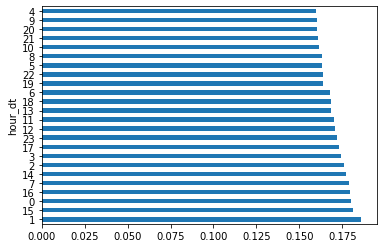

In [37]:
train["hour_dt"] = train.index.hour
train.groupby("hour_dt")["click"].mean().sort_values(ascending = False)
train.groupby("hour_dt")["click"].mean().sort_values(ascending = False).plot.barh()

- 00, 01am and 14, 15, 16h seems to have higher click rate

### site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_ip, device_model

In [38]:
enc_cols = ["site_id", "site_domain", "site_category", "app_id", "app_domain", "app_category", "device_id", "device_ip", "device_model"]

In [39]:
train[enc_cols].head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model
time,,,,,,,,,
2014-10-21,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24
2014-10-21,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120
2014-10-21,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd
2014-10-21,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a
2014-10-21,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2


- These columns seem to use the same methods to encode. Encoded values always have 8 characters<br>
- Does values in a column appears in another columns? maybe but not check yet. If yes, the same encoded values has high probability to be the same values (before encode)

In [40]:
train[enc_cols].nunique()

site_id             4737
site_domain         7745
site_category         26
app_id              8552
app_domain           559
app_category          36
device_id        2686408
device_ip        6729486
device_model        8251
dtype: int64

- Intuitively, category columns have less unique values than id columns<br>
- device_ip is converted from ip address xxx.xxx.xxx.xxx

### C1,  banner_pos, device_type, device_conn_type

C1


1005    37140632
1002     2220812
1010      903457
1012      113512
1007       35304
1001        9463
1008        5787
Name: C1, dtype: int64

banner_pos


0    29109590
1    11247282
7       43577
2       13001
4        7704
5        5778
3        2035
Name: banner_pos, dtype: int64

KeyboardInterrupt: 

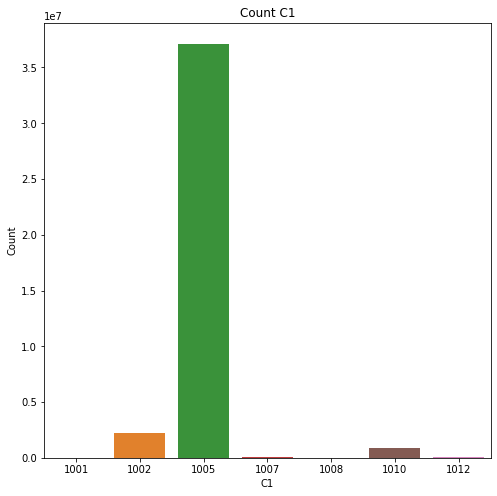

In [42]:
cols = ["C1", "banner_pos", "device_type", "device_conn_type"]
for col in cols:
    print(col)
    train[col].value_counts()    
    bar_count(train, col)

- Some interesting<br>
  - C1 lacks 1003, 1004, 1006, 1009, 1011<br>
  - banner_pos: lack 6. Values 0 and 1 takes up to 99%<br>
  - device_type: lack 3. Values 0 and 1 takes up to 98%<br>
  - device_conn_type: lack 1, 4.

In [43]:
cols = ["C1", "banner_pos", "device_type", "device_conn_type"]

In [44]:
for col in cols:
    train.groupby(col)[label].mean().sort_values(ascending = False)

C1
1002    0.210731
1012    0.172493
1005    0.169331
1008    0.121652
1010    0.095215
1007    0.039429
1001    0.033393
Name: click, dtype: float64

banner_pos
7    0.320100
4    0.185358
1    0.183614
3    0.182801
0    0.164272
5    0.121495
2    0.119222
Name: click, dtype: float64

device_type
0    0.210731
1    0.169176
4    0.095444
5    0.093842
2    0.064516
Name: click, dtype: float64

device_conn_type
0    0.181125
2    0.135289
3    0.044043
5    0.029611
Name: click, dtype: float64

- banner_pos = 7 seems have very high rate of click --> some positions of a banner seems to attract users than other positions.<br>
- device_type = 0 also have a little bit higher click rate. We can guess device type maybe: computers, tablet, phone, ..<br>
- device_conn_type = 0 have a little higher. Maybe it is randomness. I do not think that connection type will affect whether user clicks adds or not.

### C14-C21

In [45]:
cols = ["C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21"]

In [46]:
train[cols].nunique()

C14    2626
C15       8
C16       9
C17     435
C18       4
C19      68
C20     172
C21      60
dtype: int64

In [47]:
train.iloc[[100000 * i for i in range(0,20)]][cols]

,C14,C15,C16,C17,C18,C19,C20,C21
time,,,,,,,,
2014-10-21 00:00:00,15706,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,20508,320,50,2351,3,163,-1,61
2014-10-21 01:00:00,17653,300,250,1994,2,39,-1,33
2014-10-21 02:00:00,21647,320,50,2487,1,547,-1,51
2014-10-21 02:00:00,21611,320,50,2480,3,297,100111,61
2014-10-21 03:00:00,21611,320,50,2480,3,297,100111,61
2014-10-21 03:00:00,21611,320,50,2480,3,299,100111,61
2014-10-21 04:00:00,19251,320,50,2201,3,35,-1,43
2014-10-21 04:00:00,15705,320,50,1722,0,35,100083,79


In [48]:
train["C20"].value_counts().sort_index()

-1         18937918
 100000      139980
 100001        7762
 100002        7633
 100003      115705
 100004       84961
 100005       68459
 100006           5
 100008           2
 100010        1003
 100012       15157
 100013      198110
 100016        2343
 100019       51371
 100020       88084
 100021       57709
 100022        7951
 100024         825
 100025        8000
 100026        4857
 100027          23
 100028       50801
 100029        3436
 100031      185730
 100032        5123
 100033        3261
 100034       83067
 100037        7760
 100039       18098
 100040        6500
 100041        5285
 100043        1362
 100046        9010
 100048       47068
 100049       11985
 100050       71651
 100051        6112
 100052       11517
 100053        7573
 100054        8014
 100055       37578
 100056        3984
 100057       75078
 100058        8206
 100059       39136
 100060       46179
 100061       39796
 100062       21543
 100063       11695
 100064        3303


- Values -1 in C20 seems NA. Its index ranges from 100000 to 100248. The index

In [49]:
for col in ["C15", "C16"]:
    train[col].value_counts().sort_index()

120         3069
216       298794
300      2337294
320     37708959
480         2137
728        74533
768         1621
1024        2560
Name: C15, dtype: int64

20          3069
36        298794
50      38136554
90         74533
250      1806334
320         2137
480       103365
768         2560
1024        1621
Name: C16, dtype: int64

- C15, C16 values are very similar.

In [52]:
for col in ["C15", "C16"]:
    train.groupby(col)[label].mean().sort_values(ascending = False)
#     bar_mean(train, col, label)

C15
768     0.425663
300     0.359358
480     0.267665
1024    0.254688
320     0.158608
216     0.127138
728     0.056968
120     0.018899
Name: click, dtype: float64

C16
1024    0.425663
250     0.421347
320     0.267665
768     0.254688
480     0.214560
50      0.158315
36      0.127138
90      0.056968
20      0.018899
Name: click, dtype: float64

- some values like 768, 1024, 320 may lead to higher click rate